
#A community benchmark for viscoplastic thermal convection in a 2-D square box
##*N. Tosi et al.

This notebook generates models from the <a name="ref-1"/>[(Tosi et al., 2015)](#cite-tosi2015community) in Underworld2. The Underworld2 results are compared to the model run on Fenics. Input files for the Fenics models were provided by Petra Maierova.

In [62]:
#%%javascript
#IPython.load_extensions('calico-document-tools');

In [63]:
# RT PIC - classic and nearest neighbour
%matplotlib inline
import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt
import matplotlib.pyplot as pyplot
import numpy as np
import os

In [64]:
# =============================================================================
# CONSTANTS and PARAMETERS
# =============================================================================
RA  = 1e2        # Rayleigh number
TS  = 0          # surface temperature
TB  = 1          # bottom boundary temperature (melting point)
YSTRESS = 1.0    # yield stress=1 in cases 1-4, =3.0..5.0 in case 5
ETA_T = 1e5
ETA_Y = 1
ETA0 = 1e-3
#TMAX = 3.2
#IMAX = 1000
XDIV, YDIV = 40, 40 # number of horizontal and vertical divisions
#C_CFL = 0.5      # Courant number
#dt = Constant(1e-10)# initial value of time step


CASE = 2 # select identifier of the testing case (1-5)
RES = False #Separate directory for resoltion tests
save_figs = False

##Setup Mesh

In [65]:
dim = 2

# create mesh objects
elementMesh = uw.mesh.FeMesh_Cartesian( elementType=("Q1/dQ0"), 
                                         elementRes=(XDIV,YDIV), 
                                           minCoord=(0.,0.), 
                                           maxCoord=(1.,1.)  )
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh 

In [66]:
# create fevariables
velocityField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=dim )
pressureField    = uw.fevariable.FeVariable( feMesh=constantMesh, nodeDofCount=1 )
temperatureField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1 )

In [67]:
# create some dummy fevariables for doing top and bottom boundary calculations (soon to be deprecated)
topField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1)
bottomField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1)

topField.data[:] = 0.
bottomField.data[:] = 0.

# lets ensure temp boundaries are still what we want 
# on the boundaries
for index in linearMesh.specialSets["MinJ_VertexSet"]:
    bottomField.data[index] = 1.
for index in linearMesh.specialSets["MaxJ_VertexSet"]:
    topField.data[index] = 1.

#ICs and BCs

In [68]:
# Initialise data.. Note that we are also setting boundary conditions here
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
temperatureField.data[:] = 0.

# Setup temperature initial condition via numpy arrays
A = 0.01
import math
#Note that width = height = 1
tempNump = temperatureField.data
for index, coord in enumerate(linearMesh.data):
    pertCoeff = (1- coord[1]) + A*math.cos( math.pi * coord[0] ) * math.sin( math.pi * coord[1] )
    tempNump[index] = pertCoeff;
    

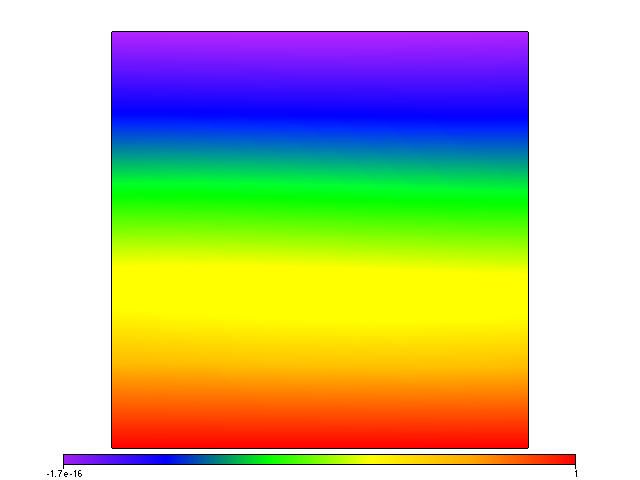

In [69]:
figtemp = plt.Figure()
figtemp.Surface(temperatureField, elementMesh)
#figtemp.Mesh(linearMesh)
figtemp.show()

In [70]:
# Get list of special sets.
# These are sets of vertices on the mesh. In this case we want to set them as boundary conditions.
linearMesh.specialSets.keys()

['MaxI_VertexSet',
 'MinI_VertexSet',
 'AllWalls',
 'MinJ_VertexSet',
 'MaxJ_VertexSet',
 'Empty']

In [71]:
# Get the actual sets 
#
#  HJJJJJJH
#  I      I
#  I      I
#  I      I
#  HJJJJJJH
#  
#  Note that H = I & J 

# Note that we use operator overloading to combine sets
IWalls = linearMesh.specialSets["MinI_VertexSet"] + linearMesh.specialSets["MaxI_VertexSet"]
JWalls = linearMesh.specialSets["MinJ_VertexSet"] + linearMesh.specialSets["MaxJ_VertexSet"]

In [72]:
# Now setup the dirichlet boundary condition
# Note that through this object, we are flagging to the system 
# that these nodes are to be considered as boundary conditions. 
# Also note that we provide a tuple of sets.. One for the Vx, one for Vy.
freeslipBC = uw.conditions.DirichletCondition(     variable=velocityField, 
                                              nodeIndexSets=(IWalls,JWalls) )

# also set dirichlet for temp field
tempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              nodeIndexSets=(JWalls,) )

In [73]:
# Set temp boundaries 
# on the boundaries
for index in linearMesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = TB
for index in linearMesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = TS

#Material properties


In [74]:
#Make variables required for plasticity

secinvCopy = fn.tensor.second_invariant( 
                    fn.tensor.symmetric( 
                        velocityField.gradientFn ))

coordinate = fn.input()

In [75]:
#Remember to use floats everywhere when setting up functions

#Linear viscosities
viscosityl1 = fn.math.exp(math.log(ETA_T)*-1*temperatureField)

viscosityl2 = fn.math.exp((math.log(ETA_T)*-1*temperatureField) + (1.-coordinate[1])*math.log(ETA_Y))

viscosityFn1 = viscosityl1 #This one always gets passed to the first velcotity solve

#Von Mises effective viscosity
viscosityp = ETA0 + YSTRESS/(secinvCopy/math.sqrt(0.5)) #extra factor to account for underworld second invariant form


if CASE == 1:
    viscosityFn2 = viscosityFn1
elif CASE == 2:
    viscosityFn2 = 2./(1./viscosityl1 + 1./viscosityp)
elif CASE == 3:
    viscosityFn2 = viscosityl2
else:
    viscosityFn2 = 2./(1./viscosityl2 + 1./viscosityp)


In [76]:
densityFn = RA*temperatureField

# Define our gravity using a python tuple (this will be automatically converted to a function)
gravity = ( 0.0, 1.0 )
# now create a buoyancy force vector.. the gravity tuple is converted to a function 
# here via operator overloading
buoyancyFn = gravity*densityFn

In [77]:
#We first set up a linear Stokes system to get the initial velocity
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              viscosityFn=fn.exception.SafeMaths(viscosityFn1), 
                              bodyForceFn=buoyancyFn)

##Build the Stokes system, solvers, advection-diffusion

 * We do one solve with linear viscisity to get the initial strain rate invariant


In [78]:
#Solve for initial velocity field - so we can begin the non-linear part
stokesPIC.solve()

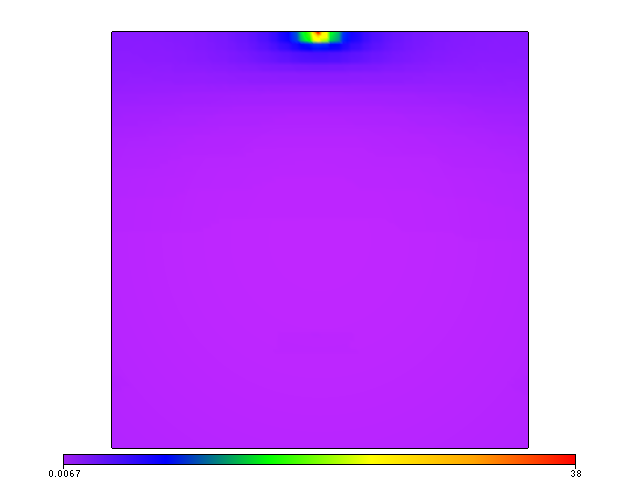

In [79]:
# lets take a look at the eta function
figEta = plt.Figure()
figEta.Surface(viscosityp, linearMesh)
figEta.show()

In [80]:
print(CASE,YSTRESS,ETA_T, ETA_Y  )

(2, 1.0, 100000.0, 1)


In [81]:
# Setup the Stokes system again, now with linear or nonlinear visocity viscosity.
stokesPIC2 = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              viscosityFn=fn.exception.SafeMaths(viscosityFn2), 
                              bodyForceFn=buoyancyFn )

In [82]:
solver = uw.systems.Solver(stokesPIC2)

In [83]:
# Create advdiff system
advDiff = uw.systems.AdvectionDiffusion( temperatureField, velocityField, diffusivity=1., conditions=[tempBC,] )
# Also create some integral objects which are used to calculate statistics.
v2sum_integral  = uw.utils.Integral( feMesh=linearMesh, fn=fn.math.dot(velocityField, velocityField) ) 
volume_integral = uw.utils.Integral( feMesh=linearMesh, fn=1. )

##Metrics for benchmark

For cases 1-4, participants were asked to report a number of diagnostic quantities to be measured after reaching steady state:

* Average temp... $$  \langle T \rangle  = \int^1_0 \int^1_0 T \, dxdy $$
* Top and bottom Nusselt numbers... $$N = \int^1_0 \frac{\partial T}{\partial y} \rvert_{y=0/1} \, dx$$
* RMS velocity over the whole domain, surface and max velocity at surface
* max and min viscosity over the whole domain
* average rate of work done against gravity...$$\langle W \rangle = \int^1_0 \int^1_0 T u_y \, dx dy$$
* and the average rate of viscous dissipation...$$\langle \Phi \rangle = \int^1_0 \int^1_0 \tau_{ij} \dot \epsilon_{ij} \, dx dy$$

* In steady state, if thermal energy is accurately conserved, the difference between $\langle W \rangle$ and $\langle \Phi \rangle / Ra$ must vanish, so also reported is the percentage error: 

$$ \delta = \frac{\lvert \langle W \rangle - \frac{\langle \Phi \rangle}{Ra} \rvert}{max \left(  \langle W \rangle,  \frac{\langle \Phi \rangle}{Ra}\right)} \times 100% $$

In [84]:
#Setup some Integral functions. We want these outside the main loop...
tempint = uw.utils.Integral(temperatureField, linearMesh)
areaint = uw.utils.Integral(1.,linearMesh)

squaredint = uw.utils.Integral(fn.math.dot(velocityField,velocityField), linearMesh)
topareaint = uw.utils.Integral((topField*1.),linearMesh)

dwint = uw.utils.Integral(temperatureField*velocityField[1], linearMesh)

secinv = fn.tensor.second_invariant( 
                    fn.tensor.symmetric( 
                        velocityField.gradientFn ))

sinner = fn.math.dot(secinv,secinv)
vdint = uw.utils.Integral((4.*viscosityFn2*sinner), linearMesh)


#...careful

In [85]:
def avg_temp():
    return tempint.integrate()[0]

def nuss():
    nt = []
    nb = []
    grad = temperatureField.gradientFn 
    gradarray = grad.evaluate(linearMesh)
    for index in linearMesh.specialSets["MaxJ_VertexSet"]:
        nt.append(gradarray[index][1]*(1./XDIV))
    for index in linearMesh.specialSets["MinJ_VertexSet"]:
        nb.append(gradarray[index][1]*(1./XDIV))
    n1 = sum(nt)
    n0 = sum(nb)
    return abs(n1), abs(n0)
    
def rms():
    return math.sqrt(squaredint.integrate()[0]/areaint.integrate()[0])

def rms_surf():
    xvelocityField = fn.math.dot(velocityField,np.array([1.,0.]))
    return math.sqrt(squaredint.integrate()[0]/topareaint.integrate()[0])

def max_vx_surf():
    surf_vels =[]
    for index in linearMesh.specialSets["MaxJ_VertexSet"]:
        surf_vels.append(velocityField.data[index][0])
    return max(surf_vels)

def gravwork():
    return dwint.integrate()[0]

#note that viscosityFn2 is used here, so this is not case independent. 
def viscdis():
    return vdint.integrate()[0]

def visc_extr():
    testfn = fn.view.min_max(viscosityFn2)
    #evaluate on the mesh
    testfn.evaluate(linearMesh) 
    vmax, vmin = testfn.max_global(), testfn.min_global()
    return vmax, vmin
    
        

#linearMesh.specialSets["MinJ_VertexSet"]()

In [86]:
linearMesh.maxCoord[1]

1.0

In [87]:
testfn = fn.view.min_max(viscosityFn2)
#evaluate on the mesh
testfn.evaluate(linearMesh) 
testfn.max_global()

1.9290136272831258

In [88]:
test = fn.math.dot(velocityField,velocityField)
type(test)

underworld.function._math.dot

In [89]:
surf_vels =[]
for index in linearMesh.specialSets["MaxJ_VertexSet"]:
    surf_vels.append(velocityField.data[index][0])
max(surf_vels)

0.12625138816353604

##solve using internal Picard iteration

In [90]:
# Stepping. Initialise time and timestep.
import time
realtime = 0.
step = 0
timevals = [0.]
vrmsvals = []

In [91]:
start = time.clock()
if RES:
    dfname = "results/" + "uw_results_case" + "_res" + str(XDIV) + ".dat" 
elif YSTRESS == 1.:
    dfname = "./results/" + "uw_results_case" + str(CASE) + ".dat"
elif YSTRESS == 4.:
    dfname = "results/" + "uw_results_case" + "_periodic" + str(YSTRESS) + ".dat"
else:
    dfname = "results/" + "stability/" + "uw_results_case" + "_stability" + str(YSTRESS) + ".dat"
f_o = open(os.path.join("./",dfname), 'w')
# Perform steps
#while timevals[step]< 0.4:
while step < 1000:
    #Enter non-linear loop
    solver.solve(nonLinearIterate=True)
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    advDiff.integrate(dt)
    # Increment
    realtime += dt
    step += 1
    timevals.append(realtime)
    # Calculate the Metrics
    Avg_temp = avg_temp()
    Rms = rms()
    Rms_surf = rms_surf()
    Max_vx_surf = max_vx_surf()
    Gravwork = gravwork()
    Viscdis = viscdis()
    nu1, nu0 = nuss()
    etamax, etamin = visc_extr()
    f_o.write((11*'%-15s ' + '\n') % (realtime, Viscdis, nu0, nu1, Avg_temp, Rms,Rms_surf,Max_vx_surf,Gravwork, etamax, etamin))
    if step % 500 == 0:
        print 'step =',step, 'Rms =', Rms, 'Nu bottom', nu0, 'Nu top', nu1
        ##Image
        if save_figs:
            field = temperatureField
            fig = pyplot.figure()
            ax = fig.add_subplot(1, 1, 1)
            image = np.reshape(field.data[:,0], (linearMesh.elementRes[0]+1,linearMesh.elementRes[1]+1))
            i = ax.imshow(np.flipud(image), interpolation='nearest', cmap='coolwarm', extent=[0., 1., 0., 1.])
            ax.contourf(image, cmap='coolwarm', extent=[0., 1., 0., 1.])
            fig.colorbar(i)
            fname = "temperatureField" + "_" + str(CASE) + "_" + str(step) + ".png"
            start_path = os.path.curdir 
            impath = os.path.join(start_path, "images")
            final_path = os.path.join(impath, str(CASE))
            if not os.path.isdir(final_path):
                os.makedirs(final_path)     
            fullpath = os.path.join("./images/" + str(CASE) + "/" + fname)
            #fig.savefig(fullpath, facecolor='0.95')
f_o.close()

step = 500 Rms = 563.441899981 Nu bottom 6.09322587582 Nu top 2.90883424777
step = 1000 Rms = 36.9430375154 Nu bottom 7.83551637719 Nu top 5.36720115124


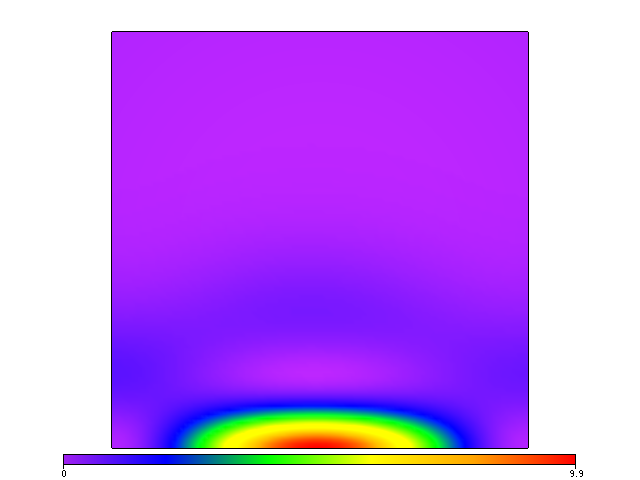

In [33]:
# lets check FEM solution
velMag = plt.Figure()
velMag.Surface(fn.math.dot(velocityField,velocityField), linearMesh)
velMag.show()

#Figures

* These figures require live data to generate - to make figures from data output see "Tosi-analysis.ipynb"

In [31]:
#Grab depth function (assumes regular mesh)
sidewall = linearMesh.specialSets["MinI_VertexSet"]
depth = coordinate.evaluate(sidewall)[:,1]

In [32]:
#Setup data arrays (numpy arrays) depth averaged Temp, Viscosity, RMS vel., Stress 

#Temp
tempdata = np.reshape(temperatureField.data[:,0], (linearMesh.elementRes[0]+1,linearMesh.elementRes[1]+1))
tempmean = tempdata.mean(axis = 1)

#Visc

vfield = viscosityFn2.evaluate(linearMesh)
viscdata = np.reshape(vfield[:,0], (linearMesh.elementRes[0]+1,linearMesh.elementRes[1]+1))
viscmean = viscdata.mean(axis = 1)

#Rms
rms = np.sqrt(np.square(velocityField.data[:,0]) + np.square(velocityField.data[:,1]))
rmsdata = np.reshape(rms, (linearMesh.elementRes[0]+1,linearMesh.elementRes[1]+1))
rmsmean = rmsdata.mean(axis = 1)

#Stress
rost = fn.tensor.second_invariant( 
                    fn.tensor.symmetric( 
                        velocityField.gradientFn ))
rostfield = rost.evaluate(linearMesh)
stressinv = 2*vfield[:]*rostfield[:]
stressdata = np.reshape(stressinv[:,0], (linearMesh.elementRes[0]+1,linearMesh.elementRes[1]+1))
stressmean = stressdata.mean(axis=1)

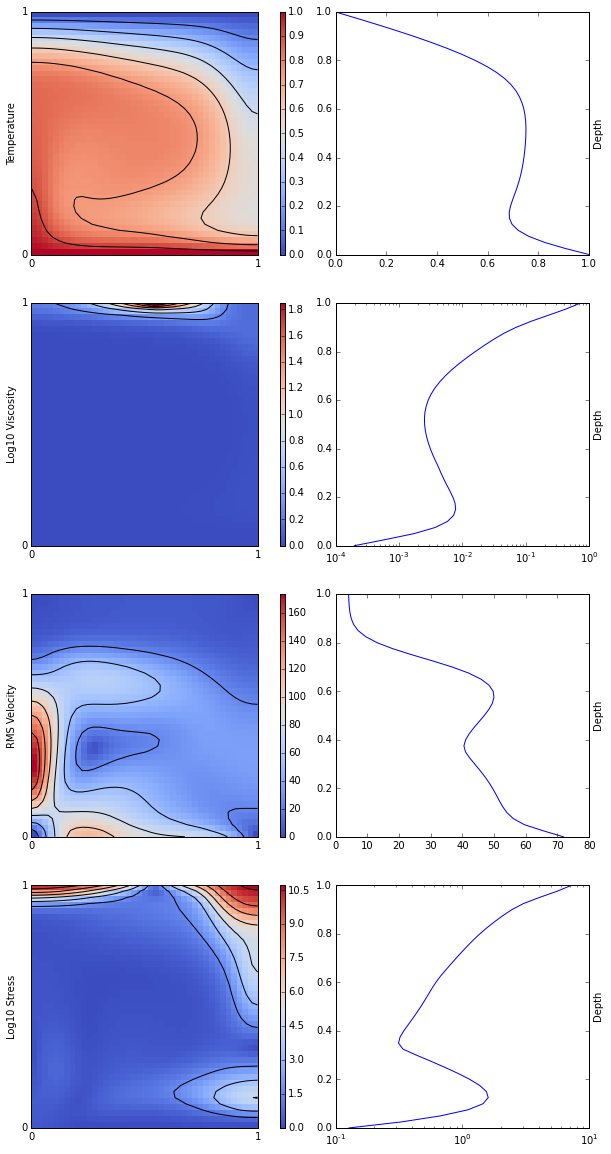

In [37]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = pyplot.figure(figsize=(10,20))


ax = fig.add_subplot(421)
ax.set_xticks([0.,1.])
ax.set_yticks([0.,1.])
ax.set_ylabel('Temperature')
i = ax.imshow(np.flipud(tempdata), interpolation='nearest', cmap='coolwarm', extent=[0., 1., 0., 1.], aspect='auto')
ax.contour(tempdata, extent=[0., 1., 0., 1.], colors = 'k')
divider = make_axes_locatable(pyplot.gca())
cax = divider.append_axes("right", "2%", pad="10%")
pyplot.colorbar(i, cax=cax)



ax = fig.add_subplot(422)
ax.set_ylabel('Depth')
ax.yaxis.set_label_position("right")
pyplot.plot(tempmean[::-1],depth[::-1])

ax = fig.add_subplot(423)
ax.set_xticks([0.,1.])
ax.set_yticks([0.,1.])
i = ax.imshow(np.flipud(viscdata), interpolation='nearest', cmap='coolwarm', extent=[0., 1., 0., 1.], aspect='auto')
ax.set_ylabel('Log10 Viscosity')
ax.contour(viscdata, extent=[0., 1., 0., 1.], colors = 'k')
divider = make_axes_locatable(pyplot.gca())
cax = divider.append_axes("right", "2%", pad="10%")
pyplot.colorbar(i, cax=cax)


ax = fig.add_subplot(424)
ax.set_ylabel('Depth')
ax.yaxis.set_label_position("right")
pyplot.plot(viscmean[::-1],depth[::-1])
ax.set_xscale('log')

ax = fig.add_subplot(425)
ax.set_xticks([0.,1.])
ax.set_yticks([0.,1.])
i = ax.imshow(np.flipud(rmsdata), interpolation='nearest', cmap='coolwarm', extent=[0., 1., 0., 1.], aspect='auto')
ax.set_ylabel('RMS Velocity')
ax.contour(rmsdata, extent=[0., 1., 0., 1.], colors = 'k')
divider = make_axes_locatable(pyplot.gca())
cax = divider.append_axes("right", "2%", pad="10%")
pyplot.colorbar(i, cax=cax)

ax = fig.add_subplot(426)
ax.set_ylabel('Depth')
ax.yaxis.set_label_position("right")
pyplot.plot(rmsmean[::-1],depth[::-1])

ax = fig.add_subplot(427)
ax.set_xticks([0.,1.])
ax.set_yticks([0.,1.])
i = ax.imshow(np.flipud(stressdata), interpolation='nearest', cmap='coolwarm', extent=[0., 1., 0., 1.], aspect='auto')
ax.set_ylabel('Log10 Stress')
ax.contour(stressdata, extent=[0., 1., 0., 1.], colors = 'k')
divider = make_axes_locatable(pyplot.gca())
cax = divider.append_axes("right", "2%", pad="10%")
pyplot.colorbar(i, cax=cax)

ax = fig.add_subplot(428)
ax.set_ylabel('Depth')
ax.yaxis.set_label_position("right")
pyplot.plot(stressmean[::-1],depth[::-1])
ax.set_xscale('log')


fig.savefig("tosi.png")


Figure 1. Steady state snapshots of temperature, viscosity, RMS velocity, second invariant of the stress tensor, and (right column) corresponding laterally averaged profiles for Case 1 obtained with the code Underworld. 

#References

<a name="cite-tosi2015community"/><sup>[^](#ref-1) </sup>Tosi, Nicola and Stein, Claudia and Noack, Lena and H&uuml;ttig, Christian and Maierov&aacute;, Petra and Samuel, Henri and Davies, DR and Wilson, CR and Kramer, SC and Thieulot, Cedric and others. 2015. _A community benchmark for viscoplastic thermal convection in a 2-D square box_.



<!--bibtex

@article{tosi2015community,
  title={A community benchmark for viscoplastic thermal convection in a 2-D square box},
  author={Tosi, Nicola and Stein, Claudia and Noack, Lena and H{\"u}ttig, Christian and Maierov{\'a}, Petra and Samuel, Henri and Davies, DR and Wilson, CR and Kramer, SC and Thieulot, Cedric and others},
  journal={Geochemistry, Geophysics, Geosystems},
  year={2015},
  publisher={Wiley Online Library}
}

... Other Bibtex entries go here.

-->